<a href="https://colab.research.google.com/github/Amazingkivas/ML-practice/blob/main/game_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование рейтинга видеоигр

Поставлена задача восстановления регрессии: предсказания рейтинга видеоигры, используя информацию о её разработчиках, жанрах, доступных платформах, а также текстовых данных, включающих описание игры (игровых механик, жанра) и её сюжет.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.columns', 100)
%matplotlib inline

## 1. Загрузка и чтение данных

### 1.1. Загрузка датасетов

Загрузка ключа kaggle

In [2]:
!pip install kaggle > /dev/null 2>&1
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output(wait=True)

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d matheusfonsecachaves/popular-video-games
! kaggle datasets download -d muhammadadiltalay/imdb-video-games
! unzip /content/popular-video-games.zip > /dev/null 2>&1
! unzip /content/imdb-video-games.zip > /dev/null 2>&1

Dataset URL: https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games
License(s): DbCL-1.0
 60% 5.00M/8.33M [00:00<00:00, 38.5MB/s]
100% 8.33M/8.33M [00:00<00:00, 50.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/muhammadadiltalay/imdb-video-games
License(s): CC0-1.0
  0% 0.00/1.42M [00:00<?, ?B/s]
100% 1.42M/1.42M [00:00<00:00, 106MB/s]


In [4]:
df_1 = pd.read_csv('/content/backloggd_games.csv')
df_2 = pd.read_csv('/content/imdb-videogames.csv')

In [5]:
df_1.head(3)

,Unnamed: 0,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
0,0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5,21K,4.1K,5.6K,5.5K,4.6K,3K
1,1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
2,2,Hades,"Dec 07, 2018",['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3,25K,3.5K,7.3K,4K,3.2K,2.1K


In [6]:
df_2.head(3)

,Unnamed: 0,name,url,year,certificate,rating,votes,plot,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
0,0,Spider-Man,https://www.imdb.com/title/tt5807780/?ref_=adv...,2018.0,T,9.2,"20,759","When a new villain threatens New York City, Pe...",True,True,False,False,False,True,False,False,False
1,1,Red Dead Redemption II,https://www.imdb.com/title/tt6161168/?ref_=adv...,2018.0,M,9.7,"35,703",Amidst the decline of the Wild West at the tur...,True,True,False,True,False,False,False,False,False
2,2,Grand Theft Auto V,https://www.imdb.com/title/tt2103188/?ref_=adv...,2013.0,M,9.5,"59,986",Three very different criminals team up for a s...,True,False,False,True,False,False,False,False,False


### 1.2. Слияние данных в один датасет

Оба детасета содержат информацию о годе выхода игры. Подготовим признак для слияния.

In [482]:
df_1['year'] = df_1['Release_Date'].str[-4:]
df_2.rename(columns={'name': 'Title'}, inplace=True)
df_2 = df_2.dropna(subset=['year'])
df_2['year'] = df_2['year'].astype(int)

In [483]:
df_1['year'].unique()

array(['2022', '2017', '2018', '2015', '2011', '2020', '2023', '2019',
       '2021', '2007', '2013', '2016', '1996', '1997', '2012', '2010',
       '2001', '2005', '2009', '1998', '1995', '1990', '2000', '1985',
       '1994', '2004', '2006', '2002', '1991', '1999', '2014', '2008',
       '1988', '1993', '2003', '1992', '1986', '1989', '1987', '1980',
       '2024', '1981', '2025', '1984', '1972', '1983', '1982', '1978',
       '1979', '1971', '1977', '2029', '1954', '1973', '1976', '1974',
       '1952', '1975'], dtype=object)

In [484]:
df_2['year'].unique()

array([2018, 2013, 2016, 2020, 2022, 2019, 2007, 2015, 2021, 2004, 2012,
       2002, 2009, 2010, 2008, 2017, 2011, 2023, 2014, 2005, 2001, 2025,
       2006, 2003, 1996, 1998, 1997, 1995, 1999, 1987, 1993, 2024, 2000,
       1994, 1985, 1991, 1981, 1992, 1983, 1990, 1986, 1989, 1988, 2027,
       1984, 1982, 1978, 1976, 1980, 1979, 1974, 1971, 1952, 1962, 1977,
       1972, 1973, 1975, 1970, 1964, 1969])

Первый датасет содержит пропуски по признаку "year". С учётом этого преобразуем эти данные к числовому формату.

In [485]:
df_1 = df_1[df_1['year'] != 'TBD']
df_1['year'] = df_1['year'].astype(int)

Слияние следует проводить по названию игры (Title) и году выпуска (year), так как по некоторым играм могли выходить ремейки под тем же названием. Так, например, в 2019 году выходил ремейк игры "Resident Evil 2", впервые вышедшей под этим тайтлом в 1998 году.

In [486]:
df_1[df_1['Title'] == 'Resident Evil 2']

,Unnamed: 0,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews,year
38,38,Resident Evil 2,"Jan 25, 2019","['Capcom', 'Capcom Development Division 1']",Resident Evil 2 is a remake of 1998's Resident...,"['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'Shooter']",4.3,19K,737,4.3K,2.2K,3.1K,1.3K,2019
391,391,Resident Evil 2,"Jan 21, 1998","['Capcom', 'Factor 5']",Resident Evil 2 is a sequel to the first Resid...,"['Windows PC', 'Nintendo GameCube', 'PlayStati...","['Adventure', 'Shooter']",4.2,6.3K,71,1.3K,691,1.4K,293,1998


In [487]:
df_2[df_2['Title'] == 'Resident Evil 2'].head(2)

,Unnamed: 0,Title,url,year,certificate,rating,votes,plot,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
97,97,Resident Evil 2,https://www.imdb.com/title/tt7826034/?ref_=adv...,2019,M,9.1,"7,029","Re-imagining of Resident Evil 2 (1998), with a...",True,False,False,False,False,False,False,True,False
332,332,Resident Evil 2,https://www.imdb.com/title/tt0161941/?ref_=adv...,1998,M,9.1,"5,873","Two months after the mansion events, the deadl...",True,False,False,False,False,False,False,True,False


In [488]:
df = pd.merge(df_1, df_2, on=['Title', 'year'], how='inner')
df.drop_duplicates("Unnamed: 0_x", inplace=True)
df.drop_duplicates(subset=['Title','Release_Date', 'Platforms'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.rename(columns={'rating': 'imdb_rating', 'votes': 'imdb_votes'}, inplace=True)

С точки зрения поставленной задачи будет некорректно предсказывать рейтинг по данным, сформированным уже после выхода игры. В соответствии с этим удалим ненужные признаки.

In [489]:
df.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'Release_Date', 'Plays', 'Playing', 'Backlogs', 'Wishlist', 'Lists', 'Reviews', 'year', 'url', 'imdb_rating', 'imdb_votes'], axis=1, inplace=True)

## 2. Обработка данных

In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        6698 non-null   object 
 1   Developers   6698 non-null   object 
 2   Summary      6591 non-null   object 
 3   Platforms    6698 non-null   object 
 4   Genres       6698 non-null   object 
 5   Rating       6185 non-null   float64
 6   certificate  3946 non-null   object 
 7   plot         6698 non-null   object 
 8   Action       6698 non-null   bool   
 9   Adventure    6698 non-null   bool   
 10  Comedy       6698 non-null   bool   
 11  Crime        6698 non-null   bool   
 12  Family       6698 non-null   bool   
 13  Fantasy      6698 non-null   bool   
 14  Mystery      6698 non-null   bool   
 15  Sci-Fi       6698 non-null   bool   
 16  Thriller     6698 non-null   bool   
dtypes: bool(9), float64(1), object(7)
memory usage: 477.6+ KB




*   Данные состоят из 6698 объектов и 18 признаков
*   Среди признаков присутствуют категориальные, текстовые, а также бинарные
*   Целевой числовой признак *Rating* имеет вещественный тип
*   Признаки *Summary*, *Rating* и *certificate* содержат пропуски в явном виде




### 2.1. Обработка числовых признаков

In [491]:
df['Rating'].isnull().sum() / df.shape[0]

0.07659002687369364

Признак *Rating* имеет небольшое количество пропусков. Можем заменить пропущенные значения средним.


In [492]:
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

### 2.2. Обработка категориальных признаков

In [493]:
df['certificate'].value_counts()

,count
certificate,
T,1280
M,977
E,948
E10+,446
Unrated,104
K-A,102
Not Rated,57
GA,10
AO,7


В уникальных значениях признака *certificate* содержатся возрастные рейтинги из разных систем рейтингов, а также их устаревшие названия. Похожие по смыслу названия возрастных рейтингов целесообразно будет объединить в одну группу по следующему правилу:

*   E, K-A, GA объединяются в «Everyone» — «Для всех»
*   MA-13 и PG-13 объединяются в «13+»
*   M и MA-17 объединяются в «17+»
*   Unrated и Not Rated объединяются в «UR» — не имеющие рейтинга. Сюда же будем относить пропуски.



In [494]:
replacement_dict = {
    'E': 'Everyone',
    'K-A': 'Everyone',
    'GA': 'Everyone',
    'MA-13': '13+',
    'PG-13': '13+',
    'M': '17+',
    'MA-17': '17+',
    'Unrated': 'UR',
    'Not Rated': 'UR',
    np.nan: 'UR'
}

df['certificate'] = df['certificate'].replace(replacement_dict)

Проверим пересечение уже размеченных принадлежностей к жанрам со списком всех жанров из признака *Genres*

In [495]:
genres_cols = ['Adventure', 'Action', 'Comedy', 'Crime', 'Family', 'Fantasy', 'Mystery', 'Sci-Fi', 'Thriller']
genres_df = df['Genres'].apply(eval)

all_values = [item for sublist in genres_df for item in sublist]

list(set(genres_cols) & set(all_values))

['Adventure']

Признак *Adventure* уже содержится в датасете

In [496]:
df.drop('Adventure', axis=1, inplace=True)
genres_cols.remove('Adventure')

Разделим значения признаков *Developers*, *Platforms* и *Genres* на отдельные элементы и применим к ним One-Hot
Encoding

In [497]:
import ast
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_column(df, col_name, min_def):
  def custom_tokenizer(text):
    items = ast.literal_eval(text)
    return items
  vectorizer = CountVectorizer(tokenizer=custom_tokenizer, min_df=min_def, lowercase=False)

  vector = vectorizer.fit_transform(df[col_name])

  vector_df = pd.DataFrame(vector.toarray(), columns=[f'{col_name} {word}' for word in vectorizer.get_feature_names_out()])

  df = pd.concat([df.reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)
  df = df.drop([col_name], axis=1)

  return df

df = vectorize_column(df, 'Genres', 500)
df = vectorize_column(df, 'Platforms', 250)
df = vectorize_column(df, 'Developers', 50)
for col in genres_cols:
  df[col] = df[col].astype(int)
  df.rename(columns={col: 'Genres ' + col}, inplace=True)

### 2.3. Обработка пропусков текстовых данных

In [498]:
df['Summary'].value_counts(normalize=True).head(3)

,proportion
Summary,
Cars is a racing game based on the animated movie of the same name. The player takes the role of Lightning McQueen in his quest to win the Piston Cup.,0.000455
Unsheathe your sword and take up your shield!\nThe world of Pokémon expands to include the Galar region in Pokémon Sword and Pokémon Shield!,0.000303
"Based on the animated movie, The Ant Bully puts you in the role of Lucas, a 10-year old boy who passes his time by tormenting an ant hill. Before he knows it, the ants use a magic potion to shrink him down to their size. Then they put him to work for the colony, giving him a fresh perspective on life.\nThe game is played from a 3D third-person perspective. Most actions are context-sensitive, performed with the press of one button, e.g. Lucas automatically jumps when running off a ledge. You play various missions, and receive medals upon their completion. These medals are worth varying amounts, depending on how well you played: gold is 50 points, silver is 30 points, and bronze is 10. You use these medals to unlock special abilities every time you reach 300 points. The missions mostly involve fighting enemies and collecting items scattered in the game world.",0.000303


In [499]:
df['plot'].value_counts(normalize=True).head(3)

,proportion
plot,
Add a Plot,0.240818
"After the adventures in the movie, McQueen starts the next season of the Piston Cup.",0.000896
"FIFA 08 is the 2007 installment of EA Sports' series of football video games that introduces the ""Be a Pro Mode"", where the player plays as only one player throughout the entire match.",0.000597


Признак "plot" содержит много значений "Add a Plot", которые по сути можно считать пропусками.

Избавимся от строк, содержащих пропуски в текстовых данных

In [500]:
df = df.dropna(subset=['Summary'])
df = df[df['plot'] != 'Add a Plot']

## 3. Визуализация и анализ данных

### 3.1. Числовые характеристики целевого признака - рейтинга

In [501]:
df['Rating'].describe()

,Rating
count,5017.000000
mean,3.160849
std,0.642187
min,0.600000
25%,2.800000
50%,3.200000
75%,3.600000
max,4.600000


### 3.2. Распределение рейтинга

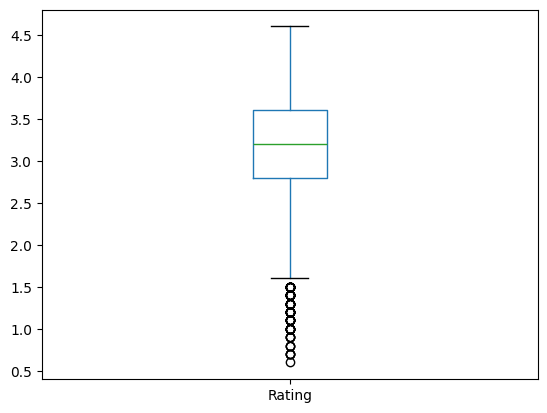

In [502]:
df.boxplot(column='Rating', grid=False)
plt.show()

На диаграмме boxplot видны выбросы, выходящие за пределы «усов».

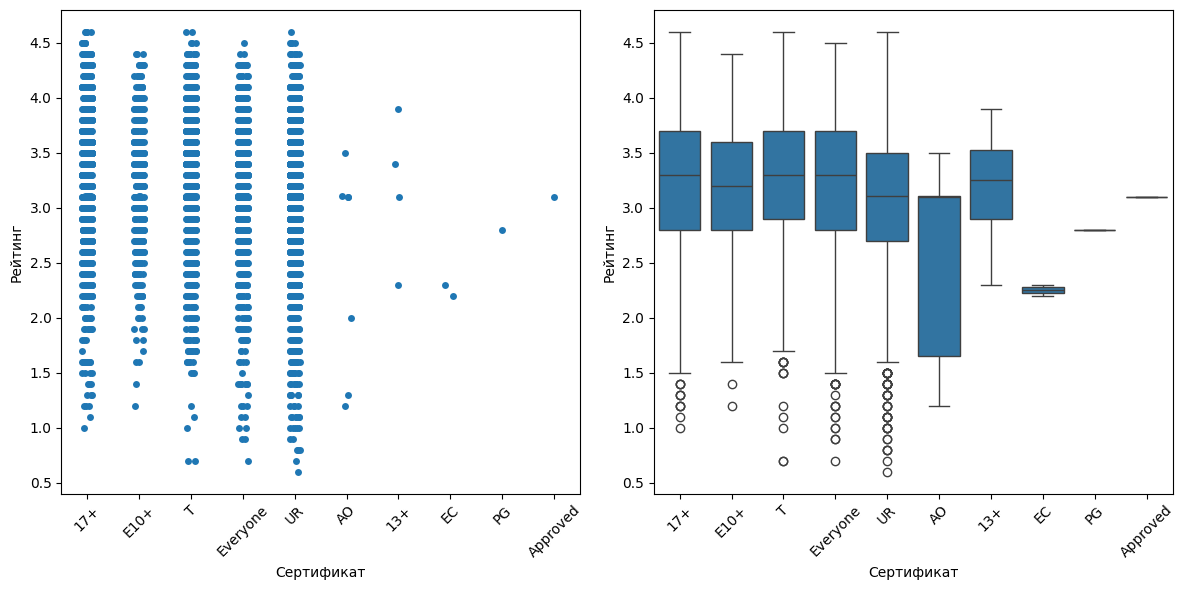

In [503]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.stripplot(x='certificate', y='Rating', data=df, jitter=True, ax=axes[0])
axes[0].set_xlabel('Сертификат')
axes[0].set_ylabel('Рейтинг')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='certificate', y='Rating', data=df, ax=axes[1])
axes[1].set_xlabel('Сертификат')
axes[1].set_ylabel('Рейтинг')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

По диаграммам, выражающим распределение рейтинга по сертификатам игры, можно сделать следующие выводы:


*   Некоторые сертификаты содержатся только у одной или у нескольких игр.
*   Для всех часто встречающихся сертификатов имеют место выбросы - игры со слишком низким рейтингом.




### 3.3. Распределение сертификатов

In [504]:
certificates = df['certificate'].value_counts(normalize=True)
certificates

,proportion
certificate,
UR,0.347419
T,0.216065
17+,0.180387
Everyone,0.176998
E10+,0.076141
AO,0.001395
13+,0.000797
EC,0.000399
PG,0.000199


In [505]:
rare_certificates_list = ['AO', '13+', 'EC', 'PG', 'Approved']
common_certificates_list = ['UR', 'T', '17+', 'Everyone', 'E10+']
rare_certificates_df = df['certificate'].value_counts(normalize=True)[rare_certificates_list]
rare_certificates_sum = rare_certificates_df.sum()

rare_certificates_sum

0.002989834562487543

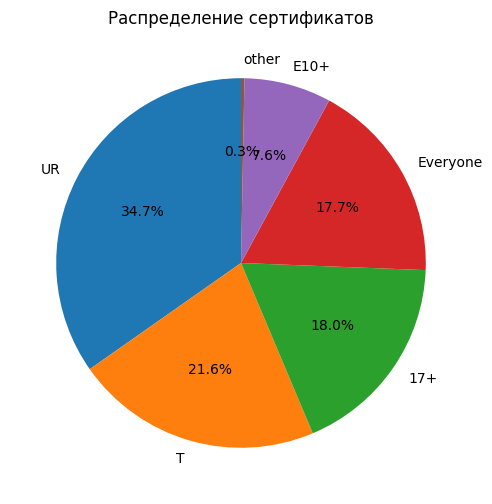

In [506]:
common_certificates_df = df['certificate'].value_counts(normalize=True)[common_certificates_list]
common_certificates_df.loc['other'] = rare_certificates_sum

plt.figure(figsize=(8, 6))
common_certificates_df.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Распределение сертификатов')
plt.ylabel('')
plt.show()

Игры с редким сертификатом составляют в сумме менее трёх промилле.

### 3.4. Визуализация распределения рейтинга в зависимости от жанра, разработчика и платформы

In [507]:
def get_data_to_visualize(col_name):
  item_columns = [col for col in df.columns if col_name in col]
  avg_rating_per_item = {item: df[df[item] == 1]['Rating'].mean() for item in item_columns}
  counts_per_item = {item: df[df[item] == 1].shape[0] for item in item_columns}

  top_item = dict(sorted(avg_rating_per_item.items(), key=lambda item: item[1], reverse=True))

  cleaned_names = [item.replace(col_name + ' ', '') for item in top_item.keys()]
  ratings = list(top_item.values())
  counts = [counts_per_item[item] for item in top_item.keys()]

  return cleaned_names, ratings, counts

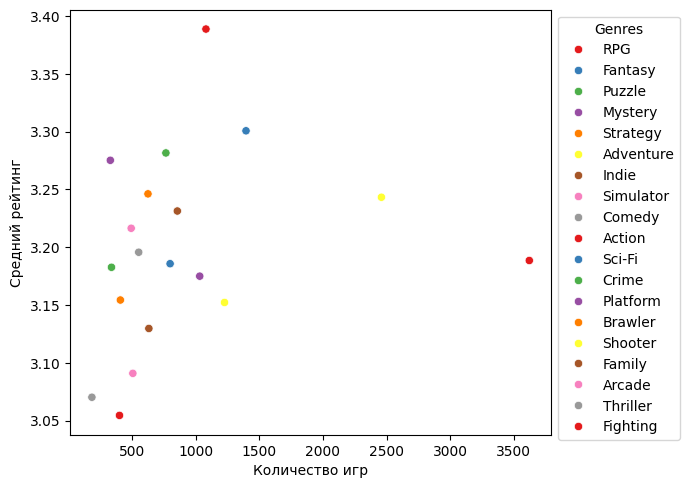

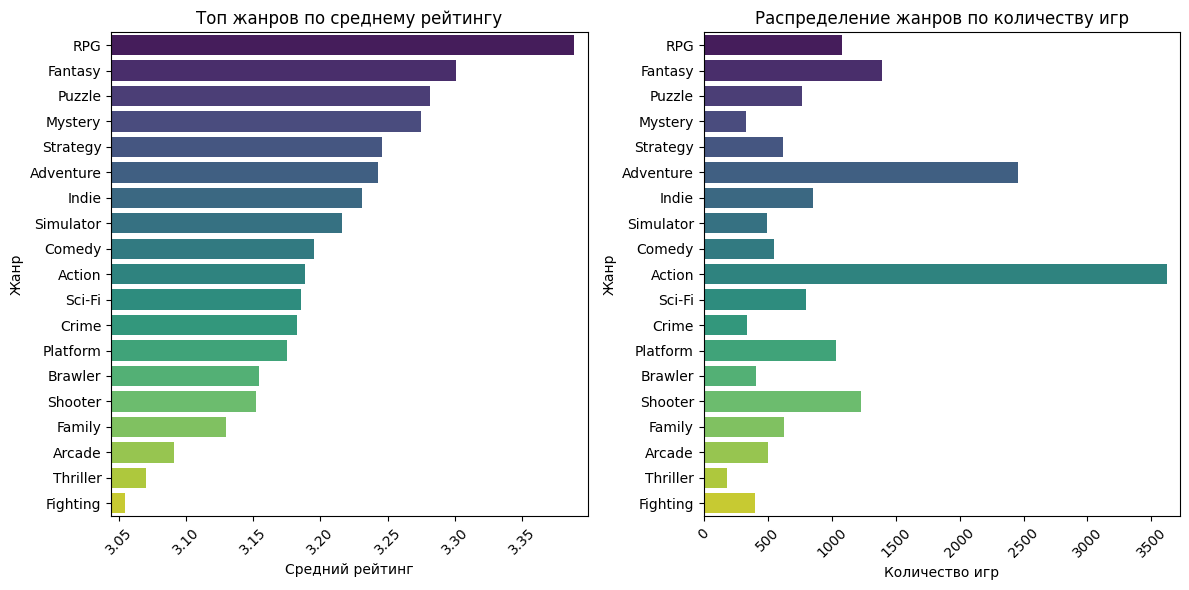

In [660]:
data = get_data_to_visualize('Genres')

genres = data[0]
ratings_g = data[1]
counts_g = data[2]

plt.figure(figsize=(7, 5))
scatter = sns.scatterplot(x=counts_g, y=ratings_g, hue=genres, palette="Set1")
plt.xlabel('Количество игр')
plt.ylabel('Средний рейтинг')

handles, labels = scatter.get_legend_handles_labels()

scatter.legend_.remove()
plt.legend(handles, labels, title='Genres', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x=ratings_g, y=genres, palette='viridis',  ax=axes[0])
axes[0].set_title(f"Топ жанров по среднему рейтингу")
axes[0].set_xlabel("Средний рейтинг")
axes[0].set_ylabel("Жанр")
axes[0].set_xlim(min(ratings_g) - 0.01, max(ratings_g) + 0.01)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=counts_g, y=genres, palette='viridis',  ax=axes[1])
axes[1].set_title(f"Распределение жанров по количеству игр")
axes[1].set_xlabel("Количество игр")
axes[1].set_ylabel("Жанр")
axes[1].set_xlim(0, max(counts_g) + 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()

plt.show()

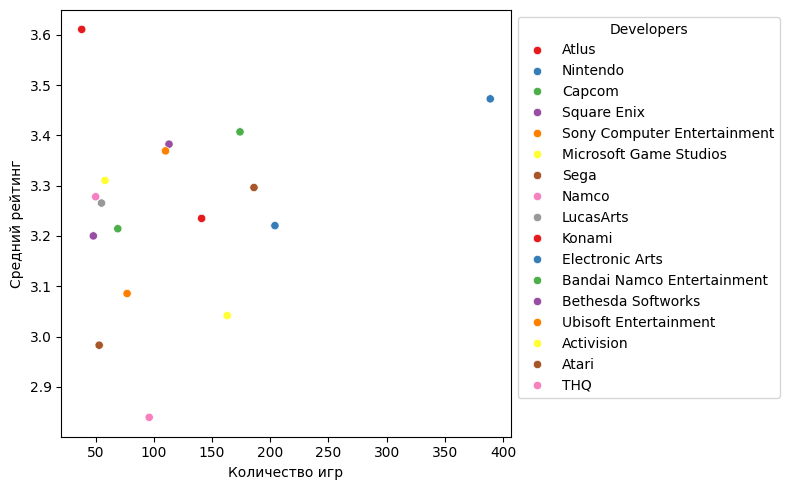

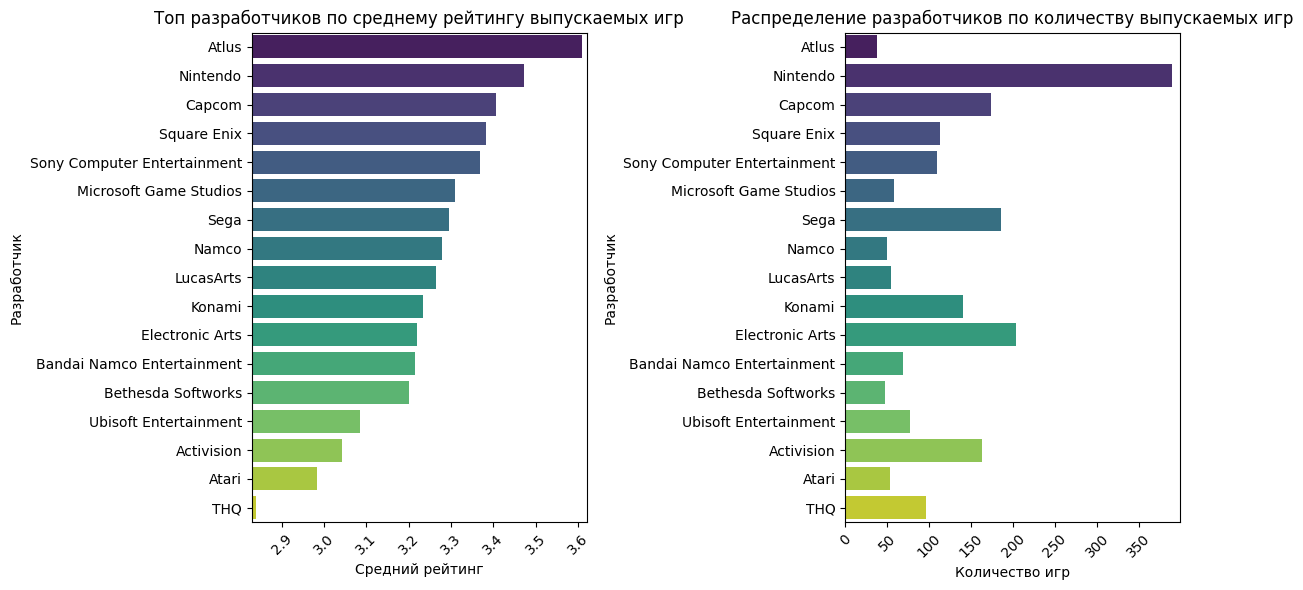

In [659]:
data = get_data_to_visualize('Developers')

developers = data[0]
ratings_d = data[1]
counts_d = data[2]

plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(x=counts_d, y=ratings_d, hue=developers, palette="Set1")
plt.xlabel('Количество игр')
plt.ylabel('Средний рейтинг')

handles, labels = scatter.get_legend_handles_labels()

scatter.legend_.remove()
plt.legend(handles, labels, title='Developers', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x=ratings_d, y=developers, palette='viridis',  ax=axes[0])
axes[0].set_title(f"Топ разработчиков по среднему рейтингу выпускаемых игр")
axes[0].set_xlabel("Средний рейтинг")
axes[0].set_ylabel("Разработчик")
axes[0].set_xlim(min(ratings_d) - 0.01, max(ratings_d) + 0.01)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=counts_d, y=developers, palette='viridis',  ax=axes[1])
axes[1].set_title(f"Распределение разработчиков по количеству выпускаемых игр")
axes[1].set_xlabel("Количество игр")
axes[1].set_ylabel("Разработчик")
axes[1].set_xlim(0, max(counts_d) + 10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()

plt.show()

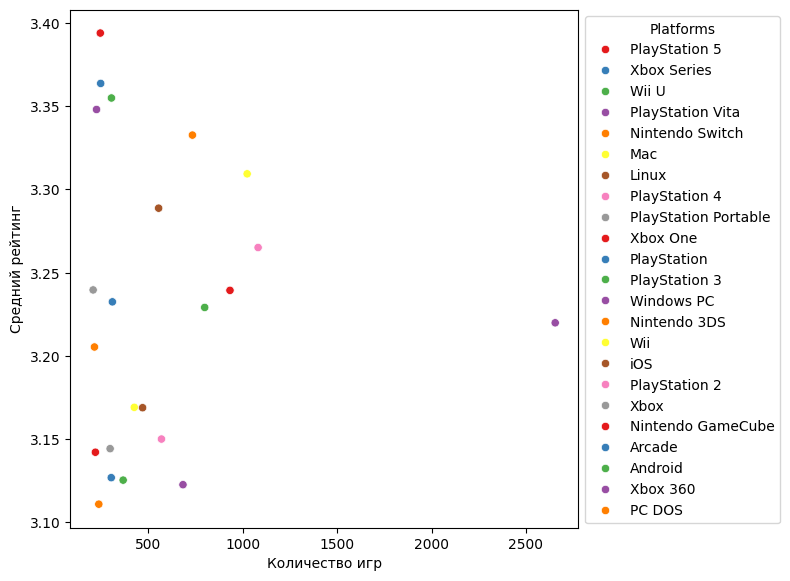

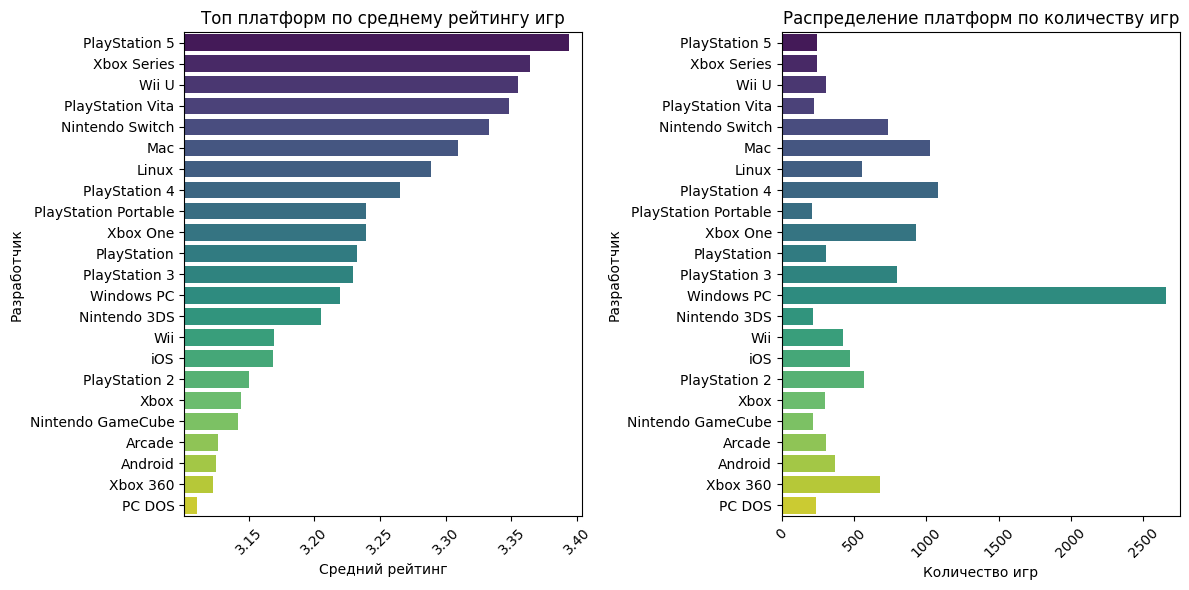

In [658]:
data = get_data_to_visualize('Platforms')

platforms = data[0]
ratings_p = data[1]
counts_p = data[2]

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=counts_p, y=ratings_p, hue=platforms, palette="Set1")
plt.xlabel('Количество игр')
plt.ylabel('Средний рейтинг')

handles, labels = scatter.get_legend_handles_labels()

scatter.legend_.remove()
plt.legend(handles, labels, title='Platforms', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x=ratings_p, y=platforms, palette='viridis',  ax=axes[0])
axes[0].set_title(f"Топ платформ по среднему рейтингу игр")
axes[0].set_xlabel("Средний рейтинг")
axes[0].set_ylabel("Разработчик")
axes[0].set_xlim(min(ratings_p) - 0.01, max(ratings_p) + 0.01)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=counts_p, y=platforms, palette='viridis',  ax=axes[1])
axes[1].set_title(f"Распределение платформ по количеству игр")
axes[1].set_xlabel("Количество игр")
axes[1].set_ylabel("Разработчик")
axes[1].set_xlim(0, max(counts_p) + 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()

plt.show()

По данным диаграммам можно примерно оценить успех игры в зависимости от жанра, разработчика и платформы. Чем ближе на диаграмме рассеивания точка к верхнему краю, тем соответствующий жанр, разработчик или платформа считается успешнее, а чем ближе к правому краю, тем с большей уверенностью можно утверждать это.

## 4. Обработка выбросов

In [514]:
def get_outliers(data, col):
  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (data[col] < lower_bound) | (data[col] > upper_bound)

Исключим объекты с редкими сертификатами и избавимся от выбросов по рейтингу

In [515]:
rare_certificates_df = ['AO', '13+', 'EC', 'PG', 'Approved']
df = df[~((df['certificate'].isin(rare_certificates_df)) | (get_outliers(df, 'Rating')))]

In [516]:
df.shape[0]

4912

## 5. Подготовка данных для обучения моделей

Заменим значения категориального признака *certificate* на порядковые номера, означающие градацию возрастного рейтинга

In [528]:
sertificate_dammy_values = {'Everyone': 0, 'E10+': 1, 'T': 2, '17+': 3, 'UR': 4}
df['certificate'] = df['certificate'].replace(sertificate_dammy_values)

Выделим исключительно необходимые для обучения данные

In [529]:
data = df.drop(['Title'], axis=1)

Нормализация текстовых данных: избавимся от знаков пунктуации и стоп-слов, переведём все слова в нижний регистр и приведём их к базовой форме.

In [530]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    text = text.lower()

    text = re.sub(r'<.*?>|[^\x00-\x7f]', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)

    stop_words = set(stopwords.words("english"))
    words = [word for word in text.split() if word not in stop_words]

    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['Summary'] = df['Summary'].apply(normalize_text)
df['plot'] = df['plot'].apply(normalize_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Сгенерируем новые данные на основе текстовых признаков, используя модель Bag of Words

In [531]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = data.drop(['Rating'], axis=1)
Y = data['Rating']

tfidf_vectorizer_summary = TfidfVectorizer()
tfidf_vectorizer_plot = TfidfVectorizer()

tfidf_summary = tfidf_vectorizer_summary.fit_transform(X['Summary'])
tfidf_plot = tfidf_vectorizer_plot.fit_transform(X['plot'])

summary_df = pd.DataFrame(tfidf_summary.toarray(), columns=tfidf_vectorizer_summary.get_feature_names_out())
plot_df = pd.DataFrame(tfidf_plot.toarray(), columns=tfidf_vectorizer_plot.get_feature_names_out())

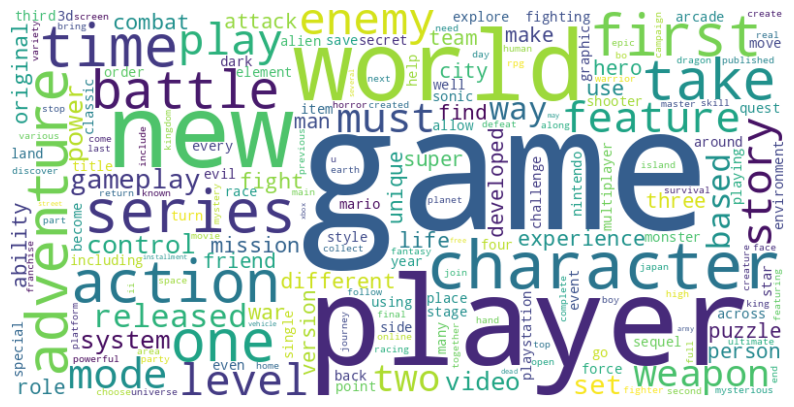

In [666]:
from wordcloud import WordCloud

combined_text = ' '.join(df['Summary'])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(combined_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

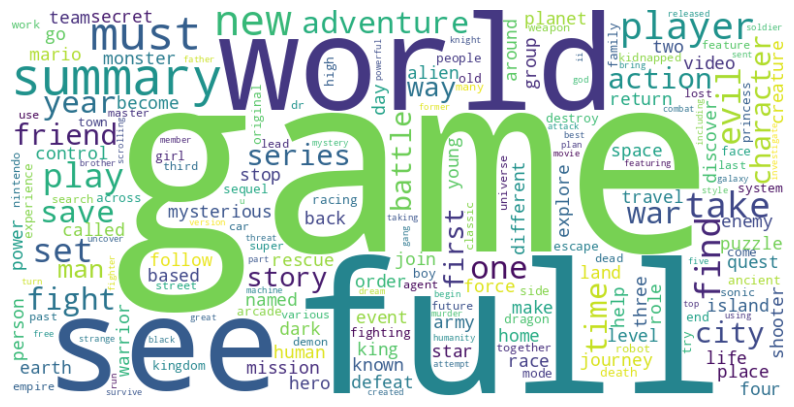

In [672]:
combined_text = ' '.join(df['plot'])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(combined_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Нормализуем признак *certificate*

In [532]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X['certificate'] = scaler.fit_transform(X[['certificate']])

Разделим данные на обучающую и тестовую выборку

In [533]:
from sklearn.model_selection import train_test_split

X_combined = pd.concat([X.drop(['Summary', 'plot'], axis=1).reset_index(drop=True), summary_df, plot_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

## 6. Обучение, запуск и оценка качества моделей

Метод k ближайших соседей (kNN)

In [540]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

knn_regressor = KNeighborsRegressor(n_neighbors=5)

knn_regressor.fit(X_train, y_train)

y_pred_train = knn_regressor.predict(X_train)
y_pred_test = knn_regressor.predict(X_test)

mse_knn_train = mean_squared_error(y_train, y_pred_train)
mse_knn_test = mean_squared_error(y_test, y_pred_test)

r2_knn_train = r2_score(y_train, y_pred_train)
r2_knn_test = r2_score(y_test, y_pred_test)

print(f'MSE Train: {mse_knn_train}')
print(f'MSE Test: {mse_knn_test}')
print(f'R2 Train: {r2_knn_train}')
print(f'R2 Test: {r2_knn_test}')

MSE Train: 0.21440075930961125
MSE Test: 0.3123353862768263
R2 Train: 0.3943765457135391
R2 Test: 0.03043099959008677


Подбор гиперпараметров метода k ближайших соседей

In [547]:
k_values = list(np.arange(1, 30))
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    y_pred_train = knn_regressor.predict(X_train)
    y_pred_test = knn_regressor.predict(X_test)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred_test))
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_test.append(r2_score(y_test, y_pred_test))

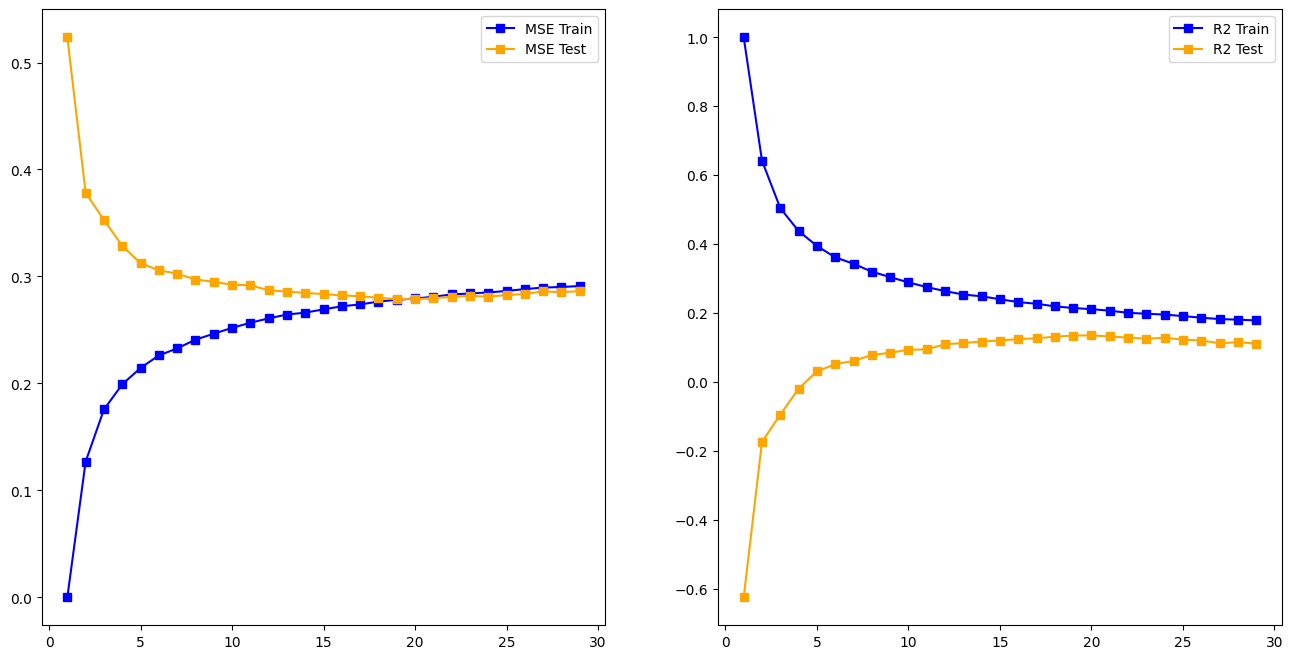

In [548]:
fig,ax = plt.subplots(1,2,figsize = (16,8))

ax[0].plot(k_values, mse_train, color='blue', marker='s', label='MSE Train')
ax[0].plot(k_values, mse_test, color='orange', marker='s', label='MSE Test')

ax[1].plot(k_values, r2_train, color='blue', marker='s', label='R2 Train')
ax[1].plot(k_values, r2_test, color='orange', marker='s', label='R2 Test')

ax[0].legend()
ax[1].legend()

plt.show()

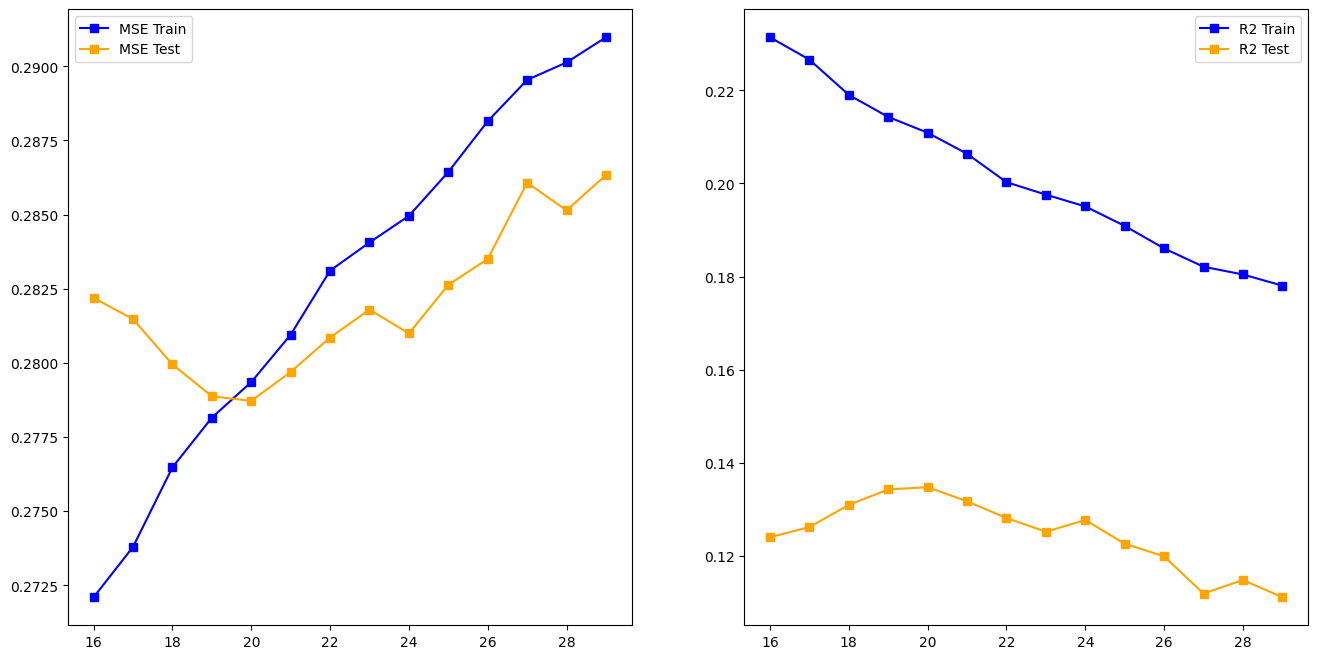

In [664]:
fig,ax = plt.subplots(1,2,figsize = (16,8))

ax[0].plot(k_values[15:], mse_train[15:], color='blue', marker='s', label='MSE Train')
ax[0].plot(k_values[15:], mse_test[15:], color='orange', marker='s', label='MSE Test')

ax[1].plot(k_values[15:], r2_train[15:], color='blue', marker='s', label='R2 Train')
ax[1].plot(k_values[15:], r2_test[15:], color='orange', marker='s', label='R2 Test')

ax[0].legend()
ax[1].legend()

plt.show()

По графикам видно что оптимальным параметром метода k ближайших соседей является k = 20

In [665]:
knn_regressor = KNeighborsRegressor(n_neighbors=20)

knn_regressor.fit(X_train, y_train)

y_pred_train = knn_regressor.predict(X_train)
y_pred_test = knn_regressor.predict(X_test)

mse_knn_train = mean_squared_error(y_train, y_pred_train)
mse_knn_test = mean_squared_error(y_test, y_pred_test)

r2_knn_train = r2_score(y_train, y_pred_train)
r2_knn_test = r2_score(y_test, y_pred_test)

print(f'MSE Train: {mse_knn_train}')
print(f'MSE Test: {mse_knn_test}')
print(f'R2 Train: {r2_knn_train}')
print(f'R2 Test: {r2_knn_test}')

MSE Train: 0.2793548015075672
MSE Test: 0.2787191020513657
R2 Train: 0.2108991572356934
R2 Test: 0.13478455197651906


## 7. Общие выводы

Предварительный анализ и текущая предобработка данных позволяют при обучении моделей достичь минимальной ошибки на тестовых данных около 0.28

Для улучшения результата можно:

*   Попробовать обучить другие методы
*   Попробовать по-разному отобрать количество разных жанров, разработчиков и платформ
*   Улучшить предобработку текстовых признаков

